# Fraud Detection on Transaction Data

## Data stuff

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import average_precision_score
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import os
os.chdir(os.getcwd())
os.chdir("C:/Users/MelodyPogula/Downloads")

In [3]:
### Data
train_df = pd.read_csv("transaction.csv")
data = train_df.copy()

X = data.drop(columns=["isFraud"])
y = data["isFraud"]

## split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=7406
)


In [4]:
cat_cols = X_train.select_dtypes(include=["object"]).columns
num_cols = X_train.select_dtypes(exclude=["object"]).columns
# one-hot encode
X_train_enc = pd.get_dummies(X_train, columns=cat_cols, drop_first=True)
X_test_enc = pd.get_dummies(X_test, columns=cat_cols, drop_first=True)
X_test_enc = X_test_enc.reindex(columns=X_train_enc.columns, fill_value=0)

## Light GBM

In [5]:
### Light GBM
lgb_train = lgb.Dataset(X_train_enc, y_train)
lgb_eval = lgb.Dataset(X_test_enc, y_test, reference=lgb_train)

'''
params = {
 "objective": "binary",
 "metric": "auc",
 "boosting_type": "gbdt",
 "learning_rate": 0.05,
 "num_leaves": 64,
 "verbose": -1
}

gbm = lgb.train(
 params,
 lgb_train,
 valid_sets=[lgb_eval],
 num_boost_round=200,
 callbacks=[lgb.early_stopping(stopping_rounds=10)]
)
'''


'\nparams = {\n "objective": "binary",\n "metric": "auc",\n "boosting_type": "gbdt",\n "learning_rate": 0.05,\n "num_leaves": 64,\n "verbose": -1\n}\n\ngbm = lgb.train(\n params,\n lgb_train,\n valid_sets=[lgb_eval],\n num_boost_round=200,\n callbacks=[lgb.early_stopping(stopping_rounds=10)]\n)\n'

In [ ]:
params = {
    "objective": "binary",
    "metric": "average_precision",
    "boosting_type": "gbdt",
    "learning_rate": 0.02,     
    "num_leaves": 127,          
    "min_data_in_leaf": 100,  
    "feature_fraction": 0.8,  
    "bagging_fraction": 0.8,   
    "bagging_freq": 1,
    "scale_pos_weight": 10,  
    "verbose": -1
}
gbm = lgb.train(
 params,
 lgb_train,
 valid_sets=[lgb_eval],
 num_boost_round=5000,
 callbacks=[lgb.early_stopping(stopping_rounds=50)]
)
pred_lgb = gbm.predict(X_test_enc)
pr_auc_lgb = average_precision_score(y_test, pred_lgb)
print(f"LightGBM PR AUC: {pr_auc_lgb:.4f}")

Training until validation scores don't improve for 50 rounds


## Cross-Validation

In [ ]:
### Cross-Validation
#cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=7406)
models = {
 "LightGBM": lgb.LGBMClassifier(
    n_estimators=5000,
    learning_rate=0.02,
    num_leaves=127,
    min_child_samples=100,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=7406,
    n_jobs=-1
)
}

In [ ]:
X_sample = X_train_enc.sample(frac=0.25, random_state=7406)
y_sample = y_train.loc[X_sample.index]

cv_results = {}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=7406)

for name, model in models.items():
    print("LightGBM Cross-Validation (5-fold, sampled) — PR AUC:")
    aucs = cross_val_score(
        model, X_sample, y_sample,
        cv=cv, scoring="average_precision", n_jobs=-1
    )
    cv_results[name] = aucs
    print(f"PR AUCs: {np.round(aucs, 4)}")
    print(f"Mean PR AUC: {np.mean(aucs):.4f} ± {np.std(aucs):.4f}")


LightGBM Cross-Validation (5-fold, sampled) — PR AUC:


KeyboardInterrupt: 

### Summary Graphs

C:\Users\MelodyPogula\AppData\Local\Temp\ipykernel_3836\2372307713.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=cv_df, x="Model", y="AUC", palette="pastel")


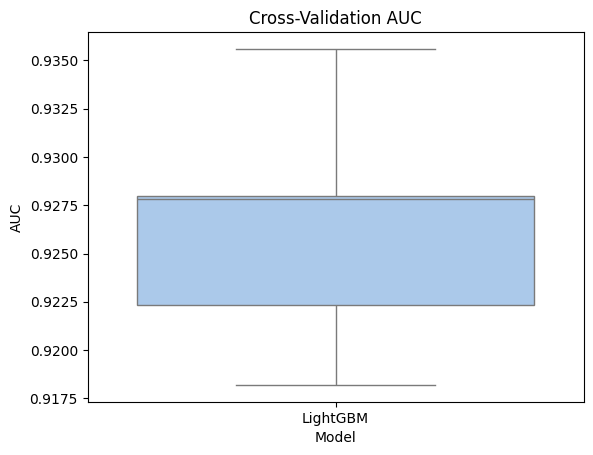

In [ ]:
### Summary graphs
cv_df = (
 pd.DataFrame(cv_results)
 .melt(var_name="Model", value_name="AUC")
)
sns.boxplot(data=cv_df, x="Model", y="AUC", palette="pastel")
plt.title("Cross-Validation AUC")
plt.xlabel("Model")
plt.ylabel("AUC")
plt.show()